In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


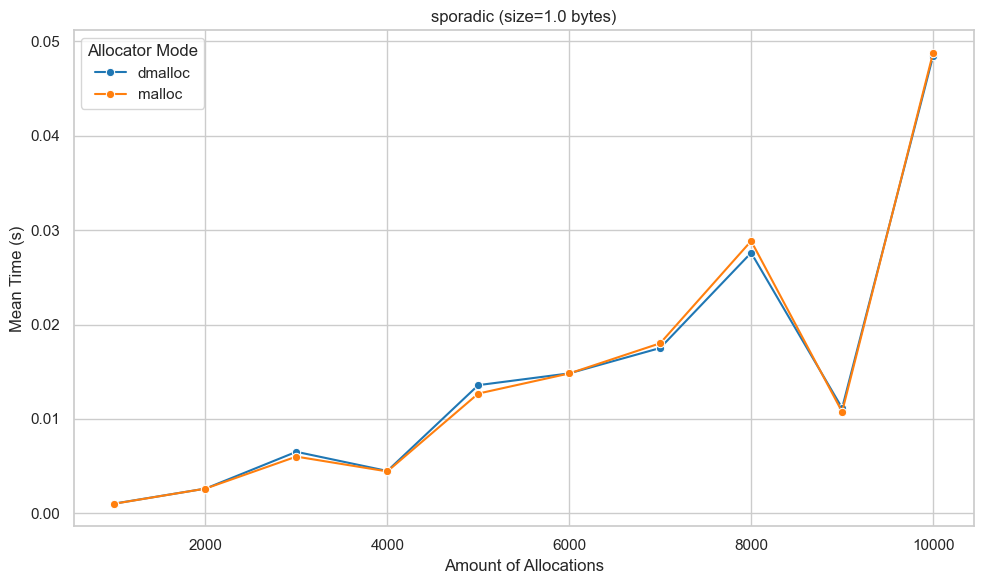

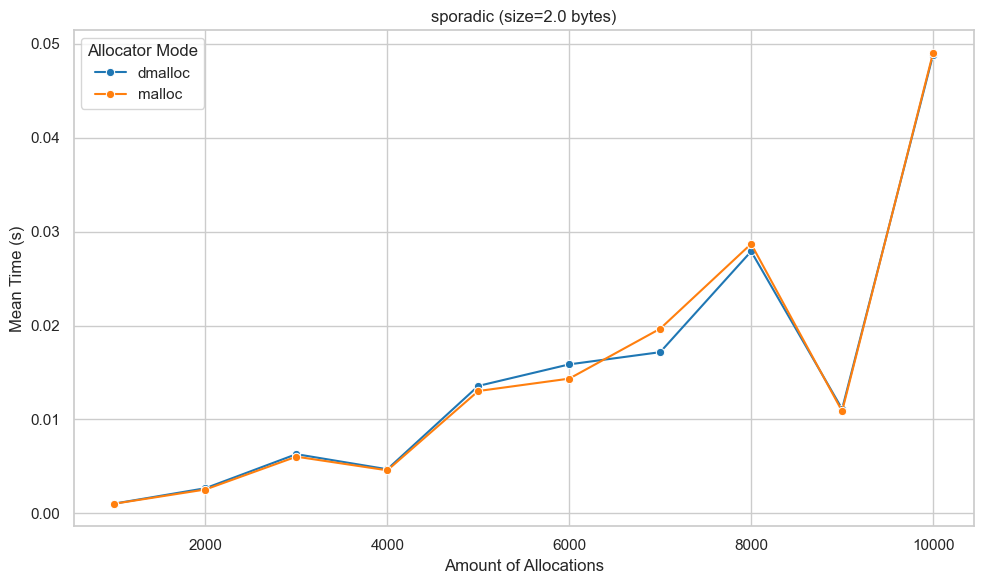

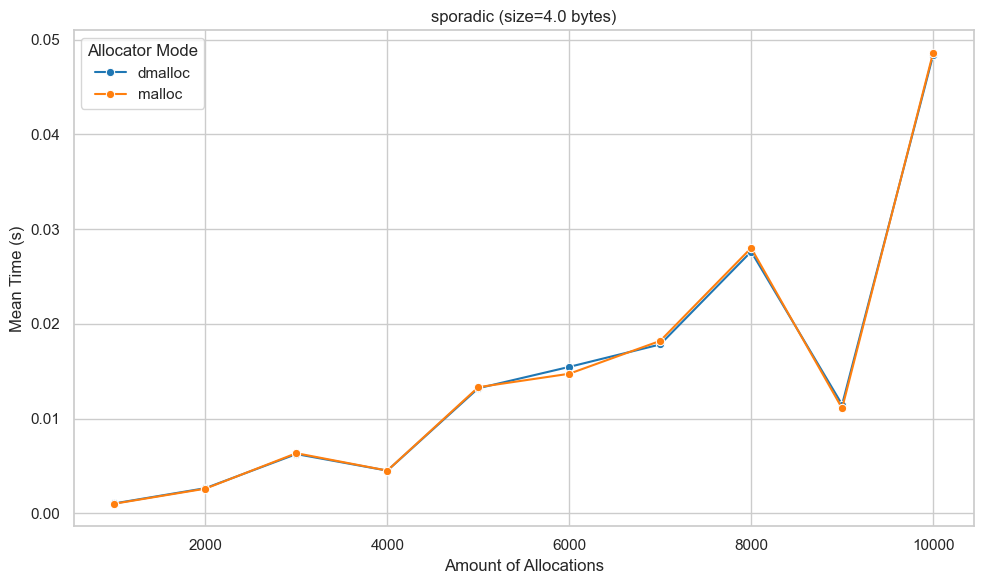

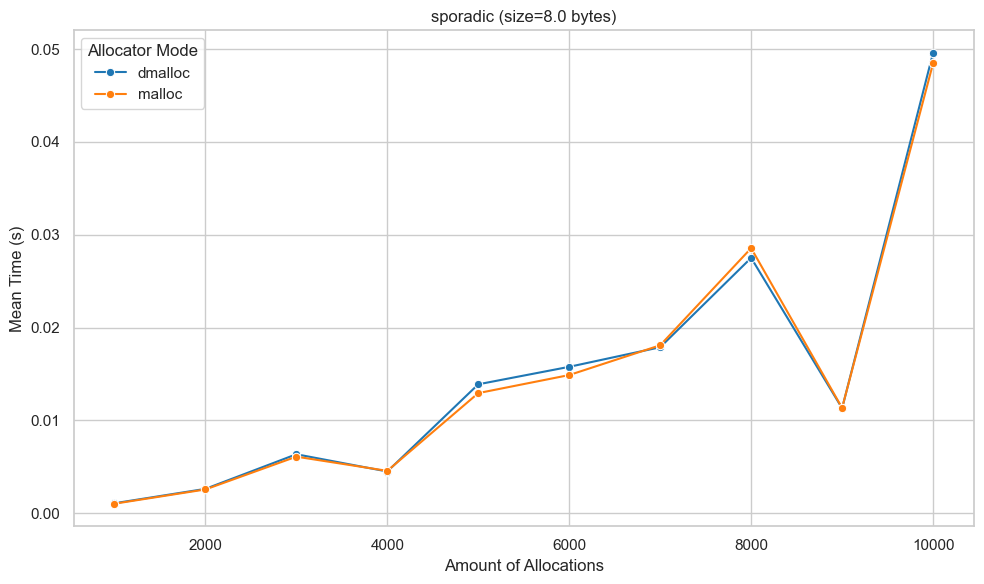

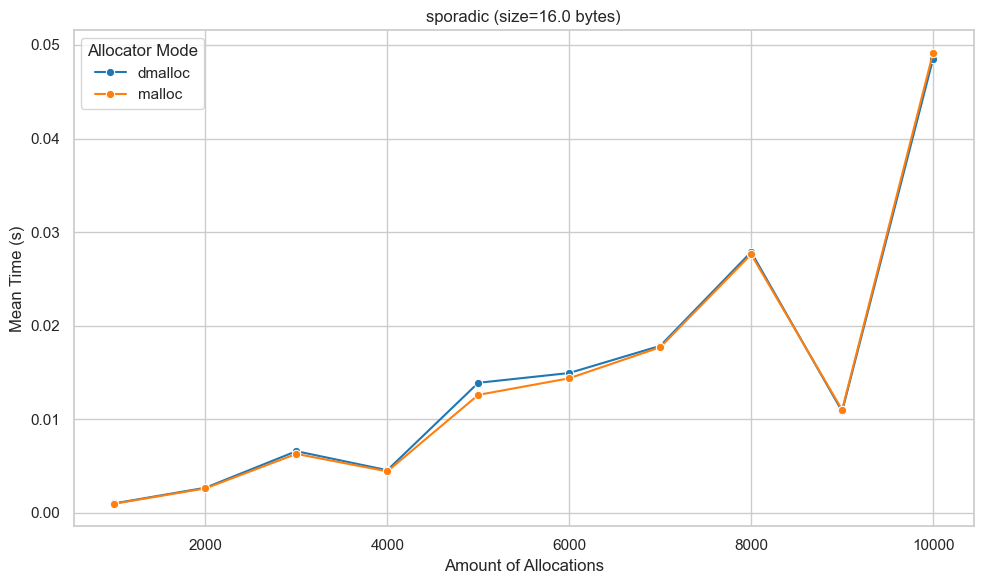

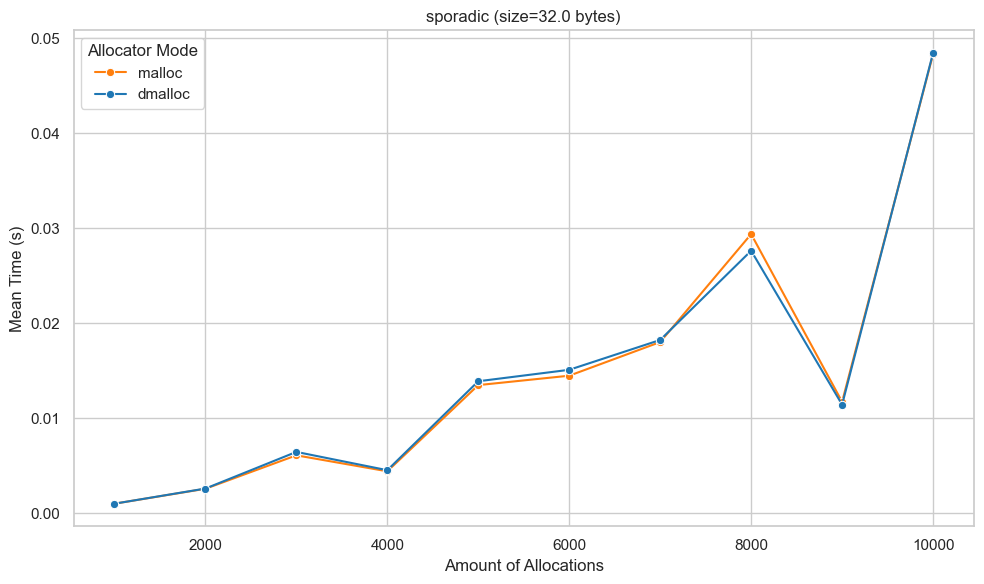

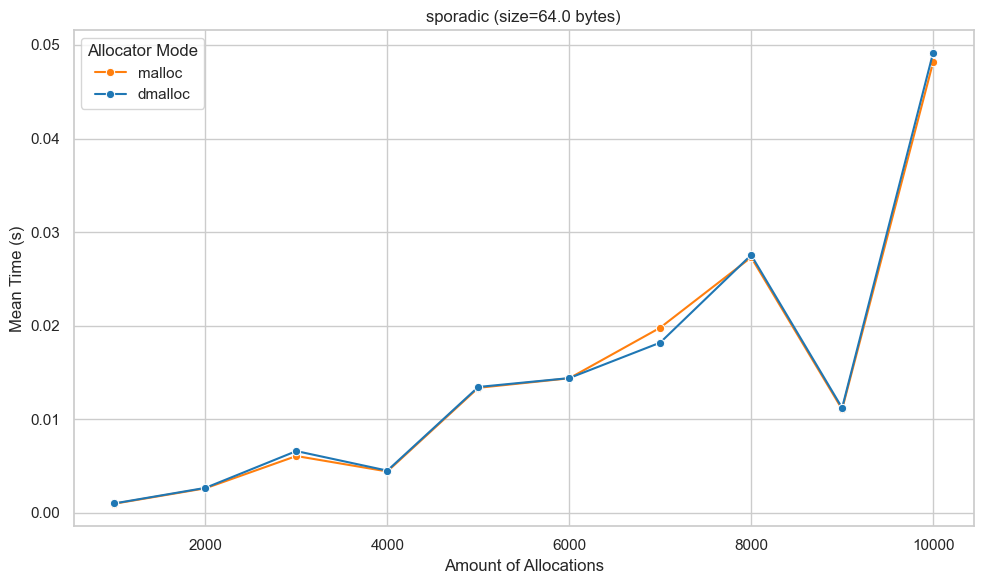

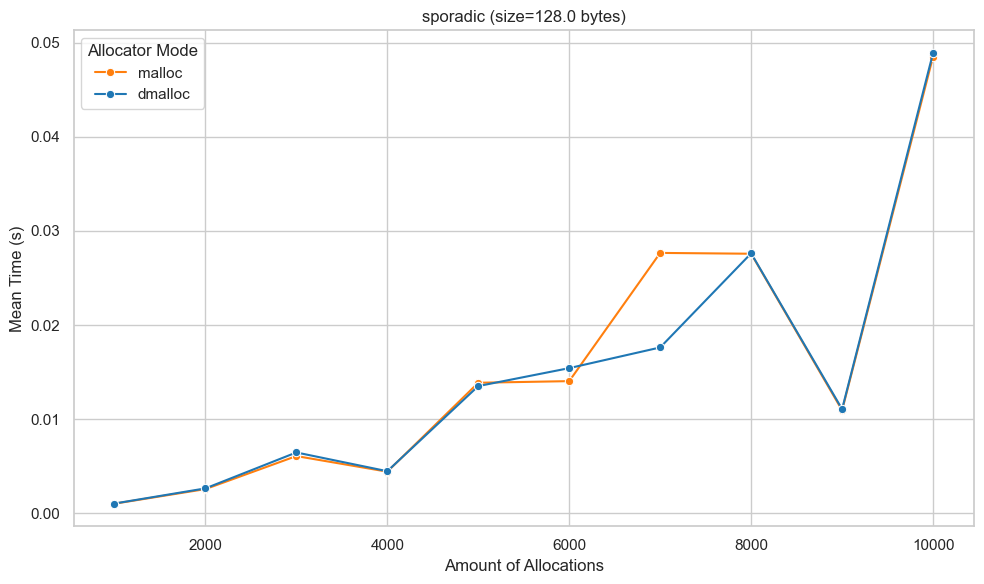

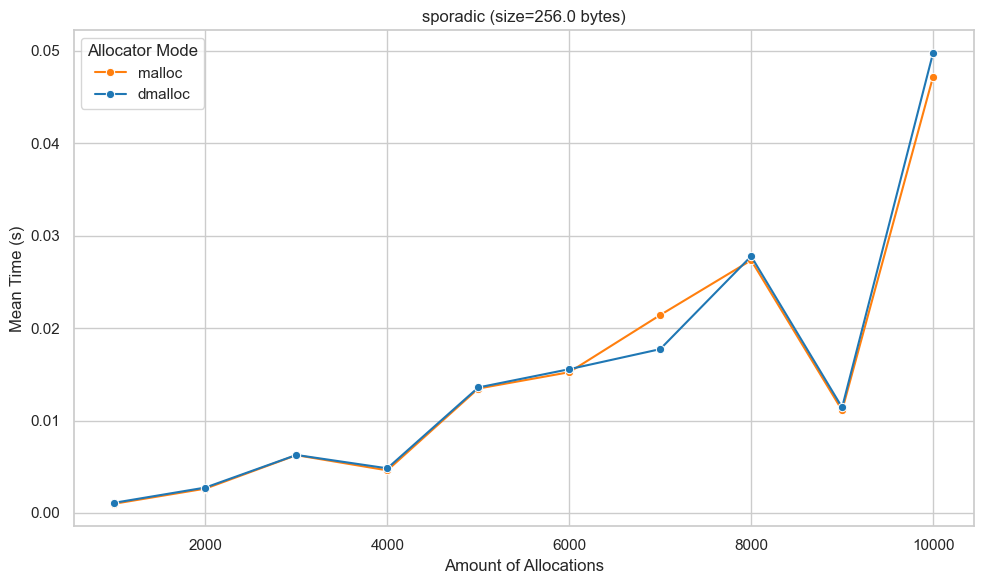

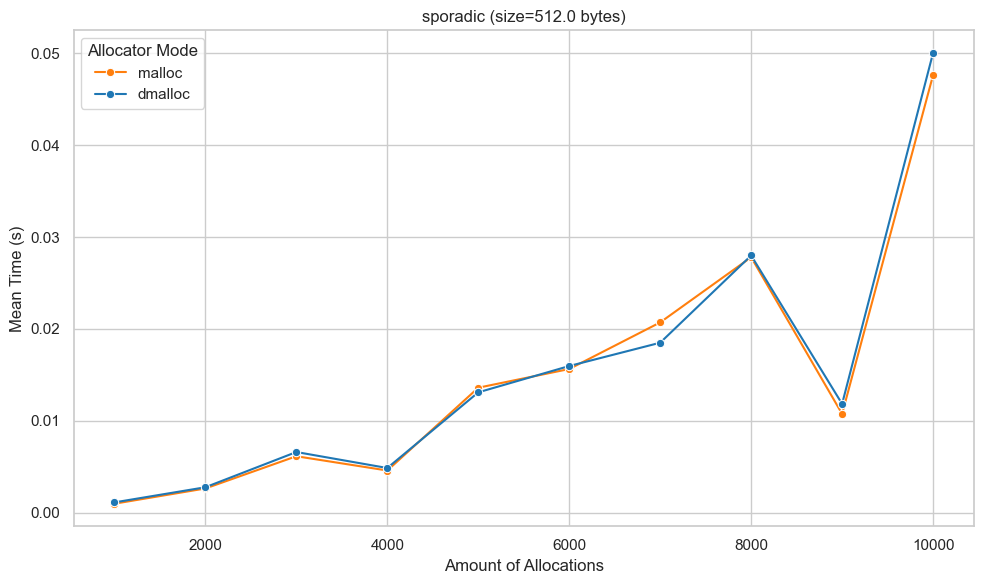

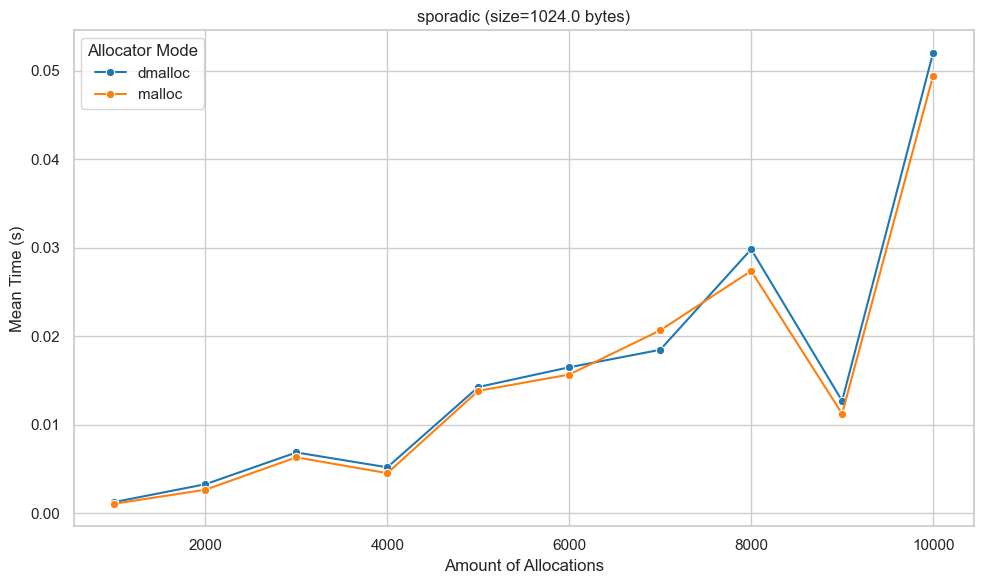

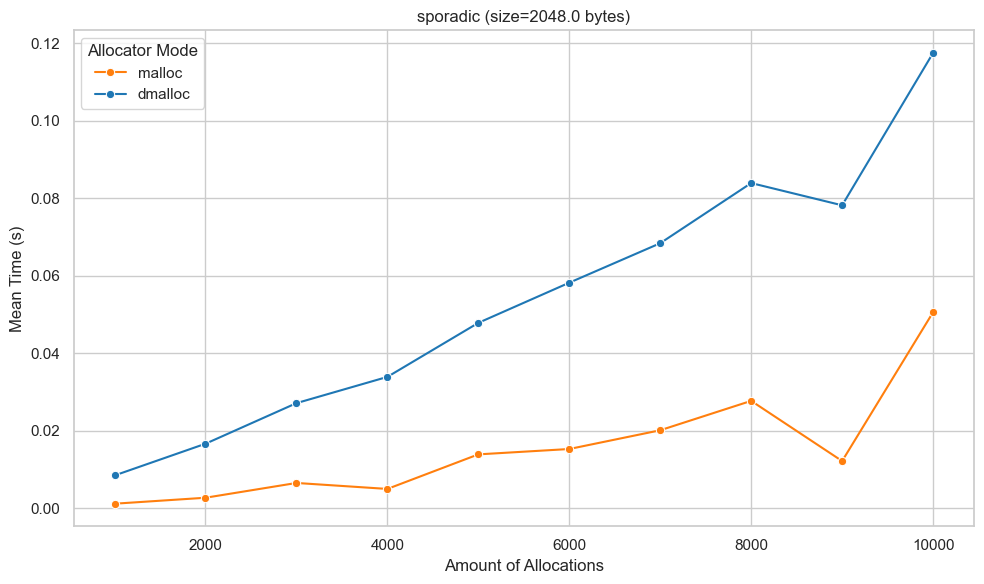

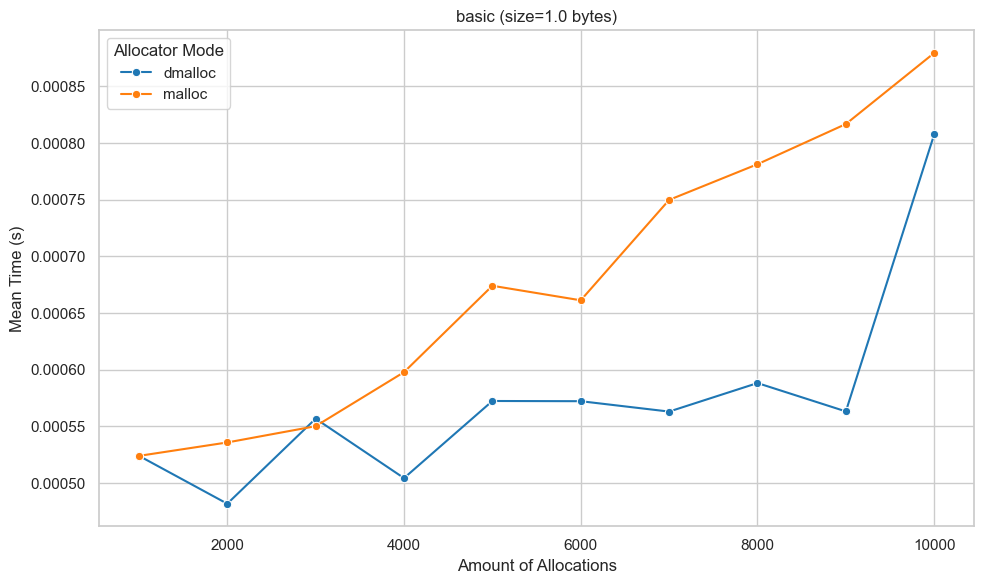

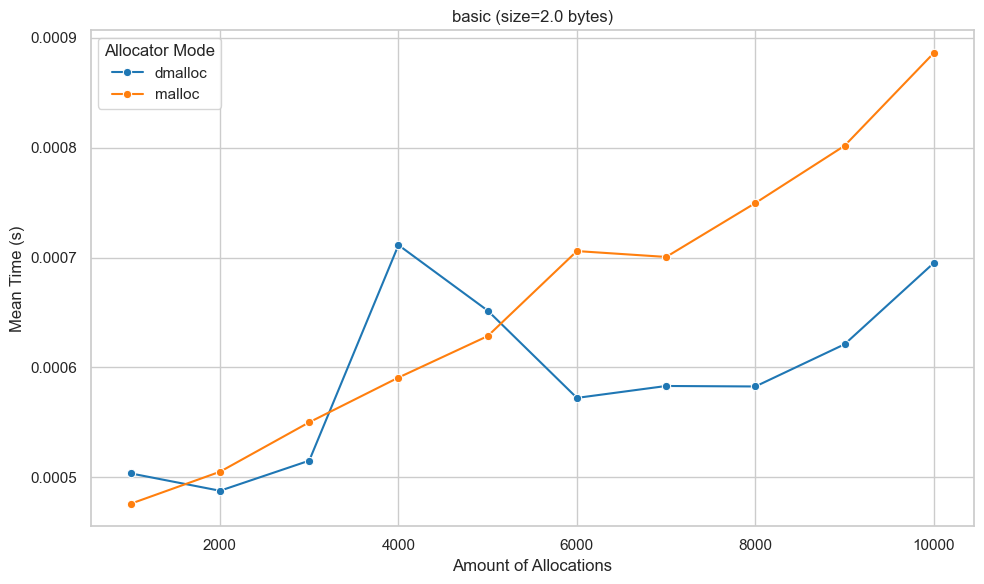

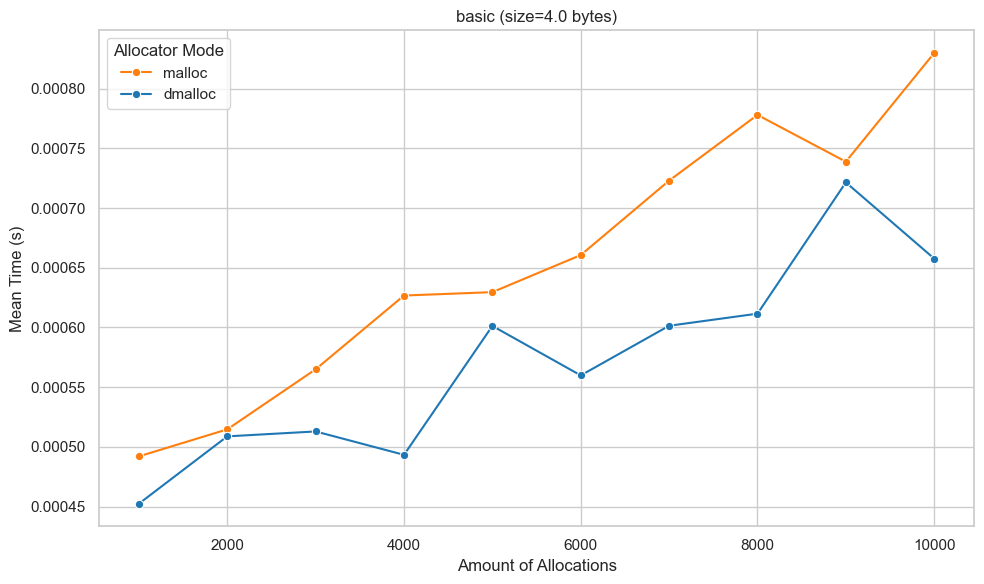

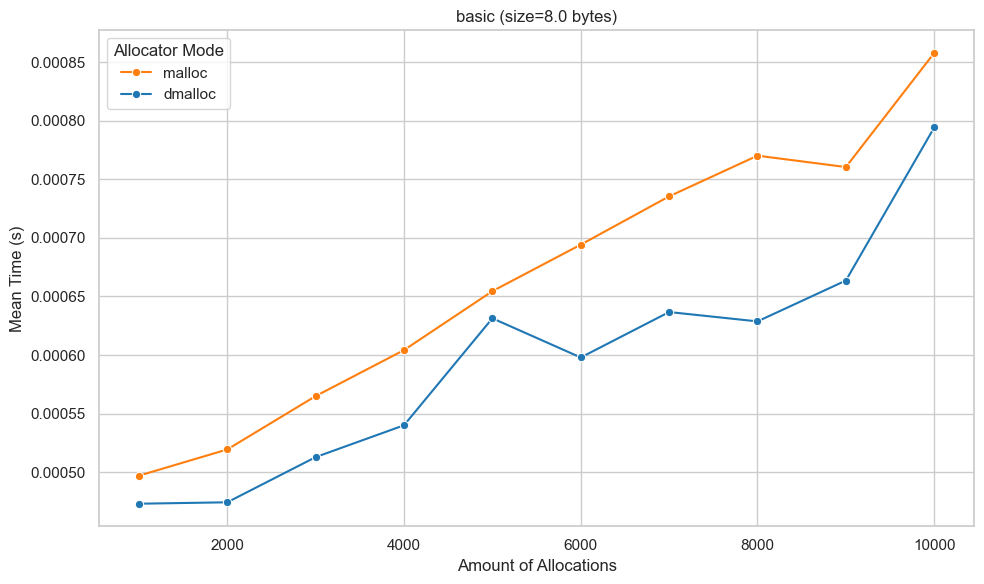

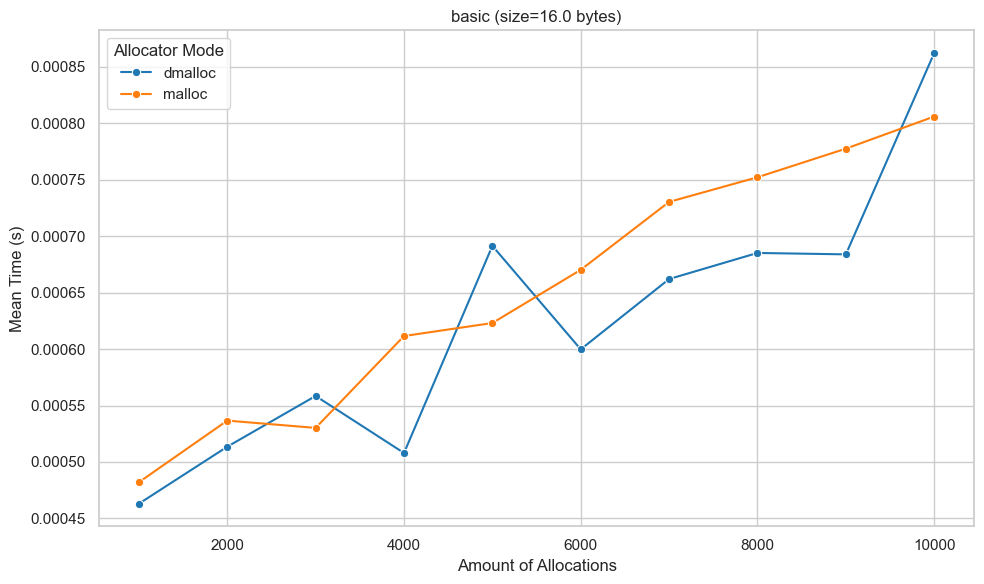

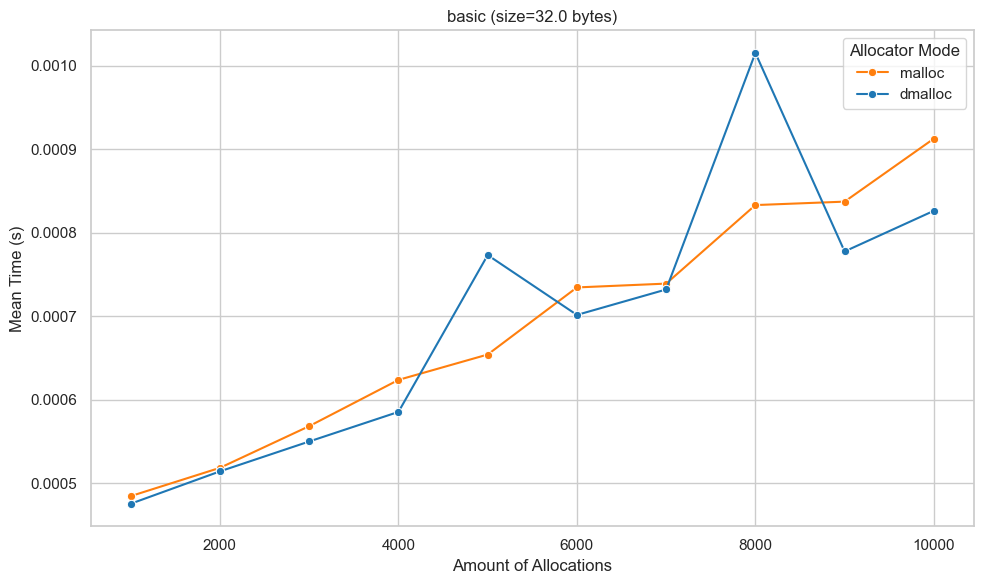

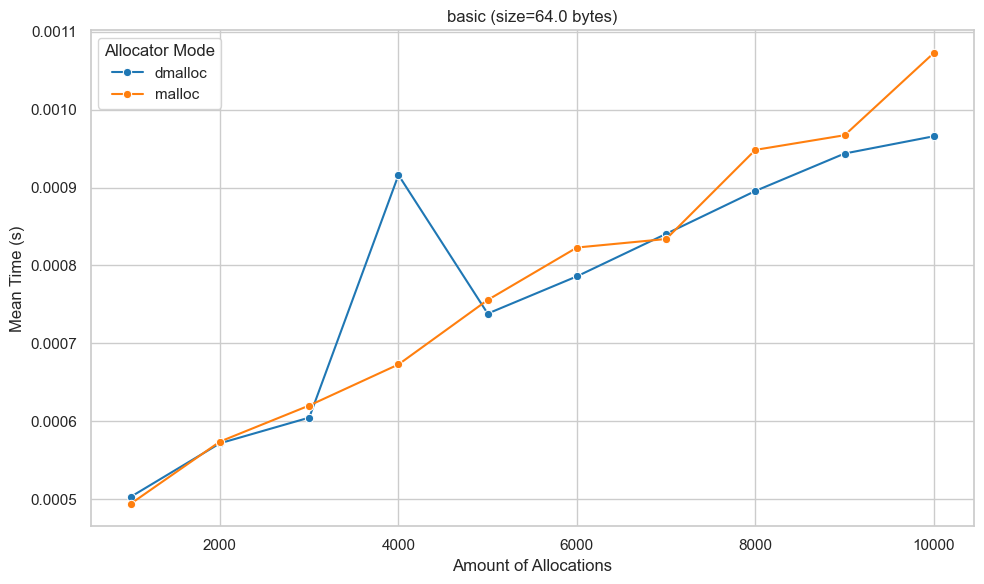

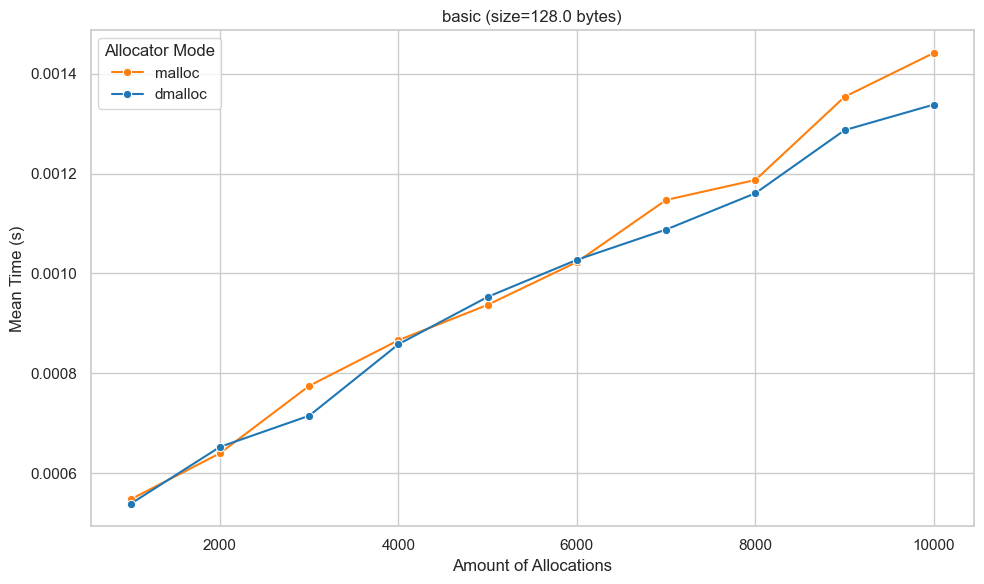

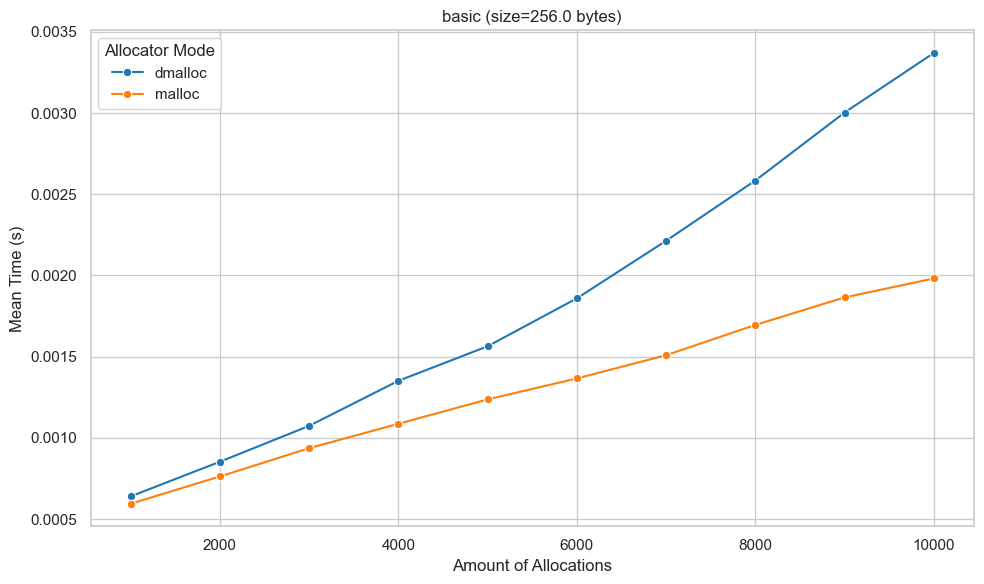

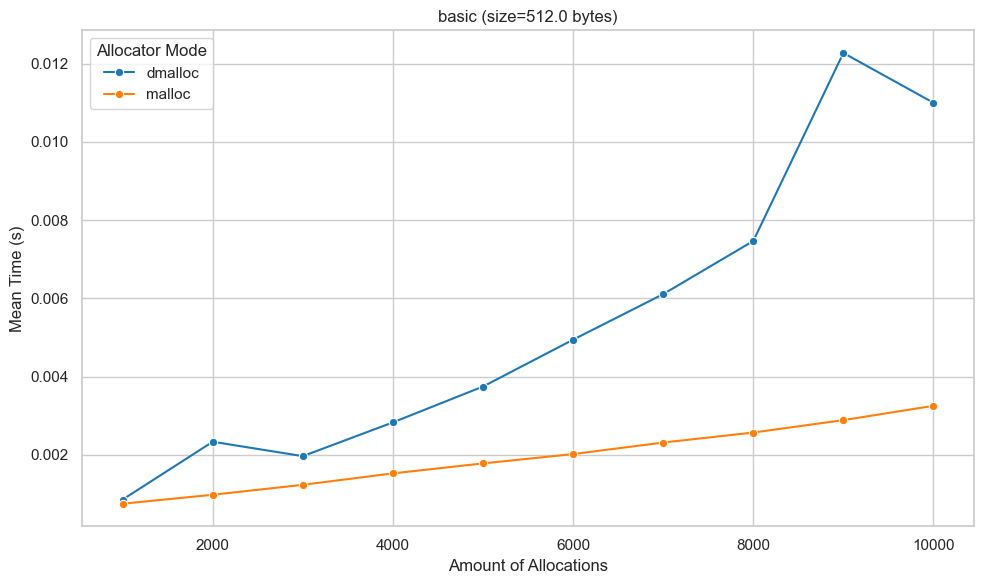

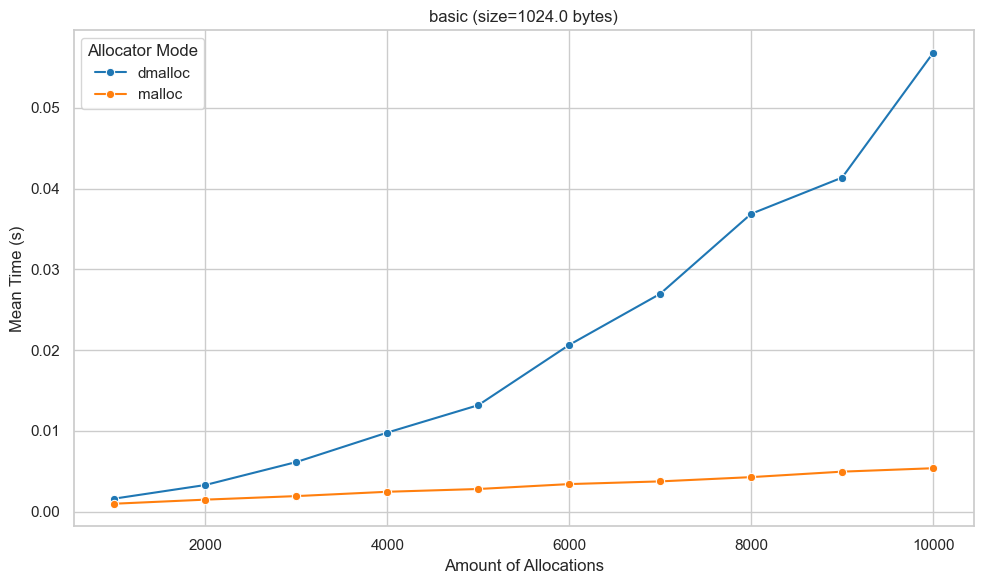

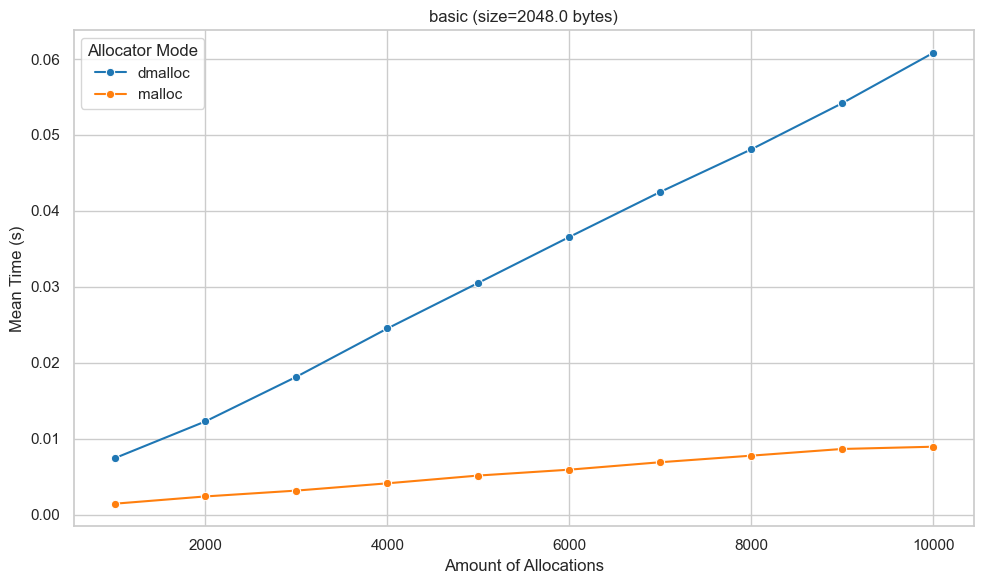

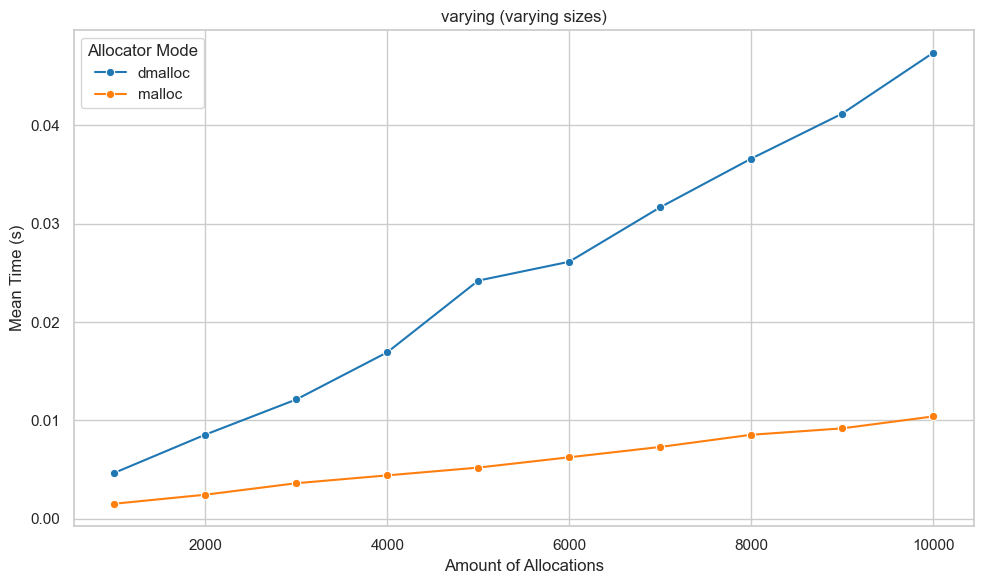

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
from pathlib import Path
from datetime import datetime

sns.set(style="whitegrid")

# Grab all result CSV files
files = glob.glob("../results/*.csv")

records = []

for filepath in files:
    filename = Path(filepath).stem  # e.g., basic_dmalloc_onlysmall_amount1000_size1

    # Match with optional _onlysmall suffix
    match = re.match(
        r"(?P<benchmark>\w+?)_(?P<allocator>\w+?)(?P<onlysmall>_onlysmall)?_amount(?P<amount>\d+)(?:_size(?P<size>\d+))?",
        filename
    )
    if not match:
        print(f"Skipping unrecognized file: {filename}")
        continue

    meta = match.groupdict()
    benchmark = meta["benchmark"]
    allocator = meta["allocator"]
    amount = int(meta["amount"])
    size = int(meta["size"]) if meta["size"] else None
    onlysmall = meta["onlysmall"] is not None

    mode = f"{allocator}_onlysmall" if onlysmall else allocator

    # Read CSV, skip command row
    df = pd.read_csv(filepath)

    row = df.iloc[0]  # Only one row per file

    records.append({
        "benchmark": benchmark,
        "allocator": allocator,
        "mode": mode,
        "amount": amount,
        "size": size,
        "mean": float(row["mean"]),
        "stddev": float(row["stddev"]),
        "min": float(row["min"]),
        "max": float(row["max"]),
    })

# Create DataFrame
df = pd.DataFrame(records)

# For plotting: treat missing sizes as a separate case (e.g. varying_allocs)
df["size"] = df["size"].fillna(-1)

# Set up the output directory
today = datetime.now().strftime("%Y-%m-%d")
output_dir = f"./benchmark_result_graphs/{today}/time"
os.makedirs(output_dir, exist_ok=True)

modes = df["mode"].unique()
palette = sns.color_palette("tab10", n_colors=len(modes))
color_mapping = dict(zip(sorted(modes), palette))

for benchmark in df["benchmark"].unique():
    bench_df = df[df["benchmark"] == benchmark]

    for size in sorted(bench_df["size"].unique()):
        size_df = bench_df[bench_df["size"] == size]

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=size_df,
            x="amount",
            y="mean",
            hue="mode",
            marker="o",
            palette=color_mapping,
        )

        title_size = " (varying sizes)" if size == -1 else f" (size={size} bytes)"
        plt.title(f"{benchmark}{title_size}")
        plt.xlabel("Amount of Allocations")
        plt.ylabel("Mean Time (s)")
        plt.legend(title="Allocator Mode")
        plt.tight_layout()

        # Prepare filename-safe benchmark name
        safe_benchmark = benchmark.replace("/", "_").replace(" ", "_")
        size_str = "varying" if size == -1 else str(size)
        file_name = f"{safe_benchmark}_size_{size_str}.png"
        file_path = os.path.join(output_dir, file_name)

        plt.savefig(file_path)
        plt.show()
        plt.close()


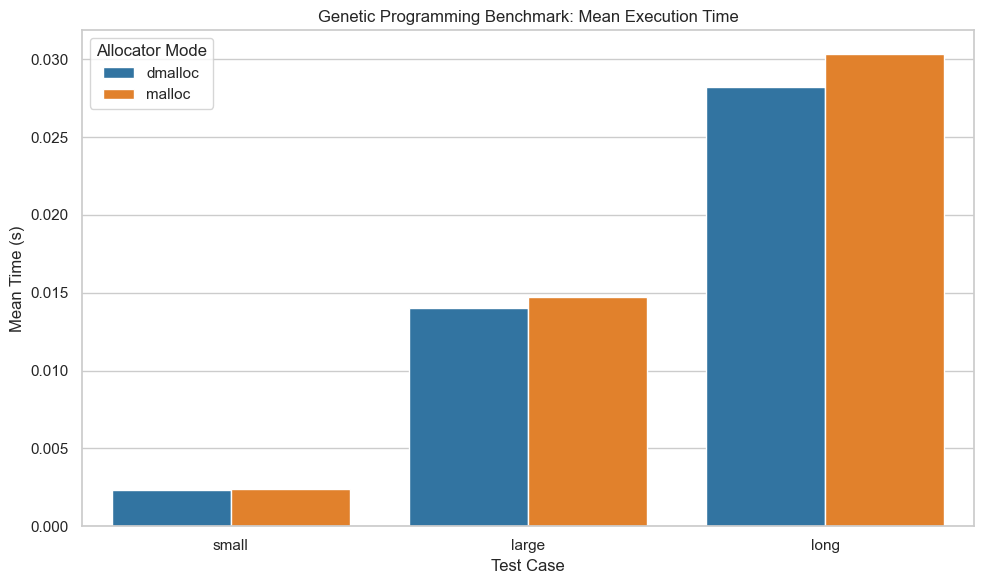

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
from pathlib import Path
from datetime import datetime

# Set seaborn style
sns.set(style="whitegrid")

# Load all genetic benchmark result files
files = glob.glob("../results/genetic/*.csv")

records = []

for filepath in files:
    filename = Path(filepath).stem  # e.g., genetic_small_dmalloc_onlysmall

    match = re.match(
        r"genetic_(?P<benchmark>small|large|long)_(?P<allocator>dmalloc|malloc)(?P<onlysmall>_onlysmall)?",
        filename
    )
    if not match:
        print(f"Skipping unrecognized file: {filename}")
        continue

    meta = match.groupdict()
    benchmark = meta["benchmark"]
    allocator = meta["allocator"]
    onlysmall = meta["onlysmall"] is not None

    mode = f"{allocator}_onlysmall" if onlysmall else allocator

    df = pd.read_csv(filepath)
    row = df.iloc[0]  # hyperfine stores only one result per file here

    records.append({
        "benchmark": benchmark,
        "allocator": allocator,
        "mode": mode,
        "mean": float(row["mean"]),
        "stddev": float(row["stddev"]),
        "min": float(row["min"]),
        "max": float(row["max"]),
    })

# Create a DataFrame
df = pd.DataFrame(records)

# Order tests if needed
test_order = ["small", "large", "long"]
df["benchmark"] = pd.Categorical(df["benchmark"], categories=test_order, ordered=True)

# Set up output directory
today = datetime.now().strftime("%Y-%m-%d")
output_dir = f"./benchmark_result_graphs/{today}/genetic"
os.makedirs(output_dir, exist_ok=True)

# Plot bar chart of mean execution times
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="benchmark",
    y="mean",
    hue="mode",
    palette="tab10",
    errorbar="sd"
)

plt.title("Genetic Programming Benchmark: Mean Execution Time")
plt.xlabel("Test Case")
plt.ylabel("Mean Time (s)")
plt.legend(title="Allocator Mode")
plt.tight_layout()

# Save and show
plt.savefig(os.path.join(output_dir, "genetic_benchmark_mean_time.png"))
plt.show()


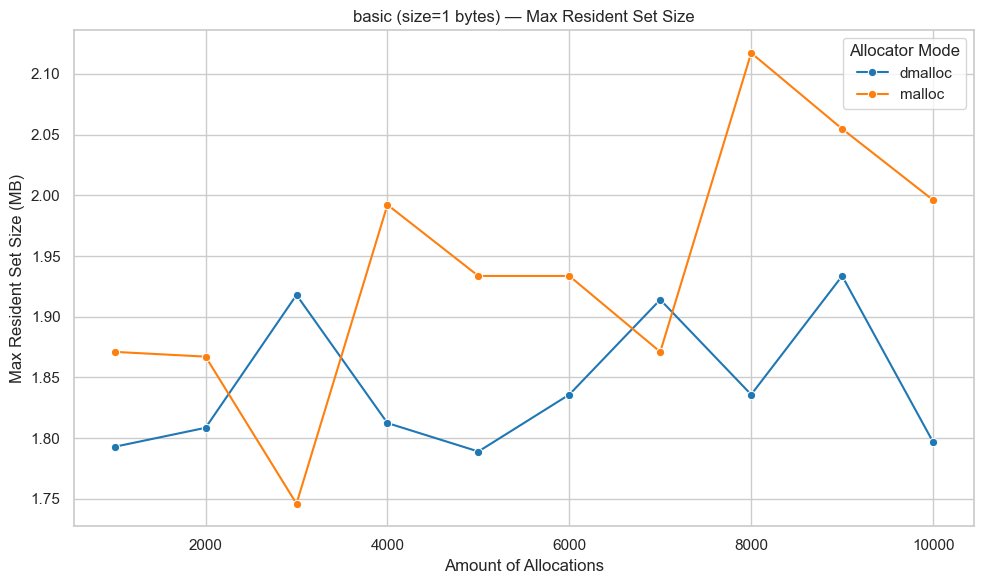

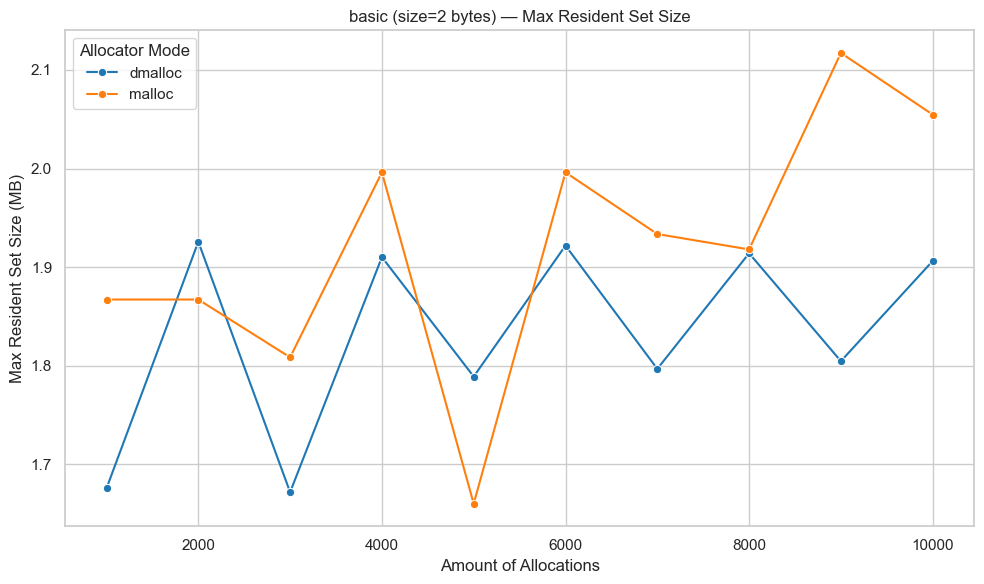

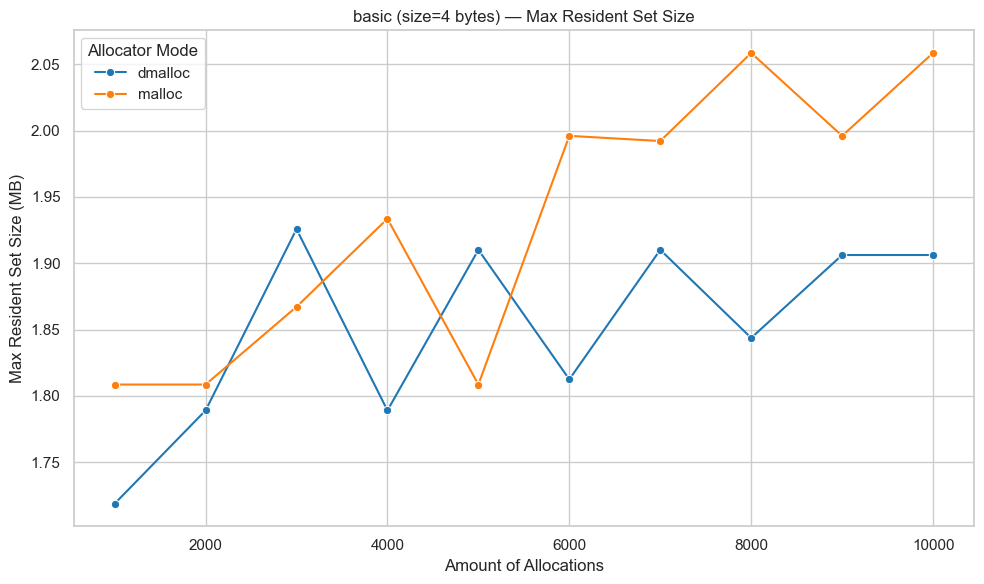

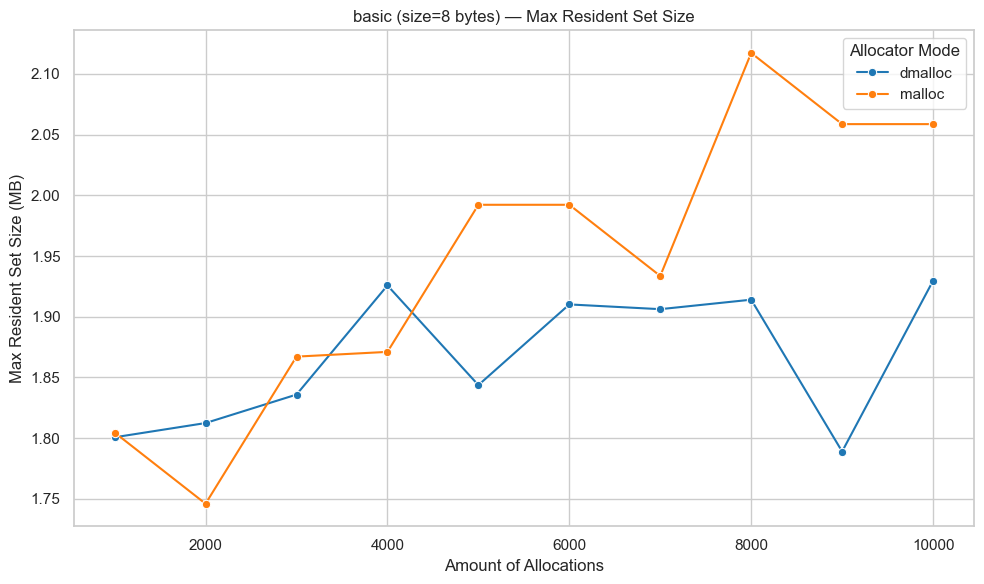

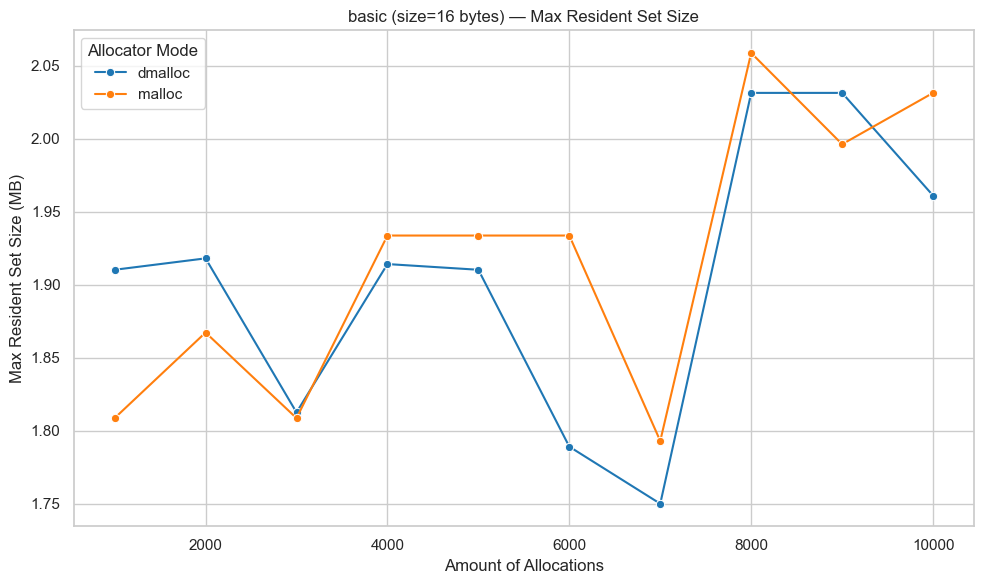

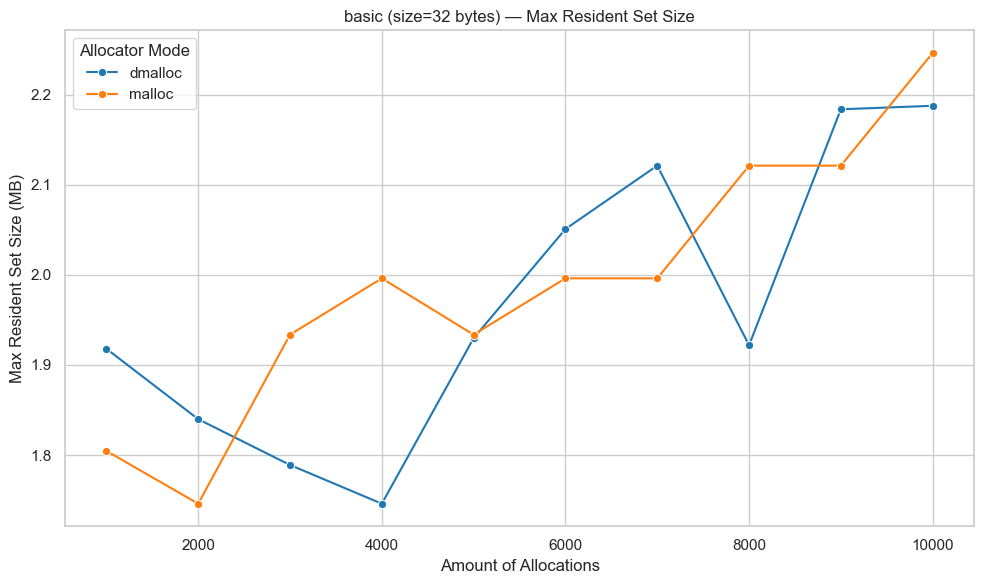

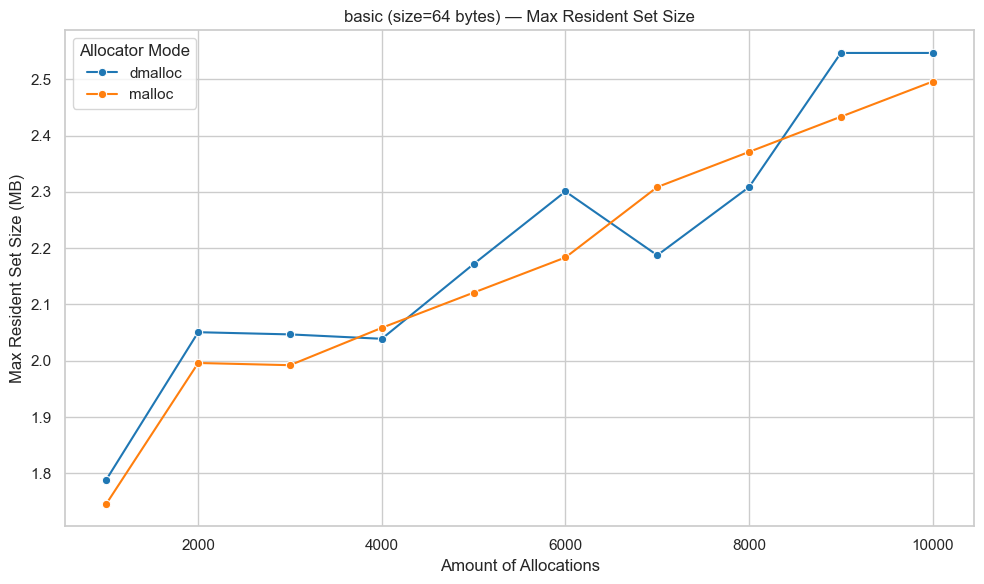

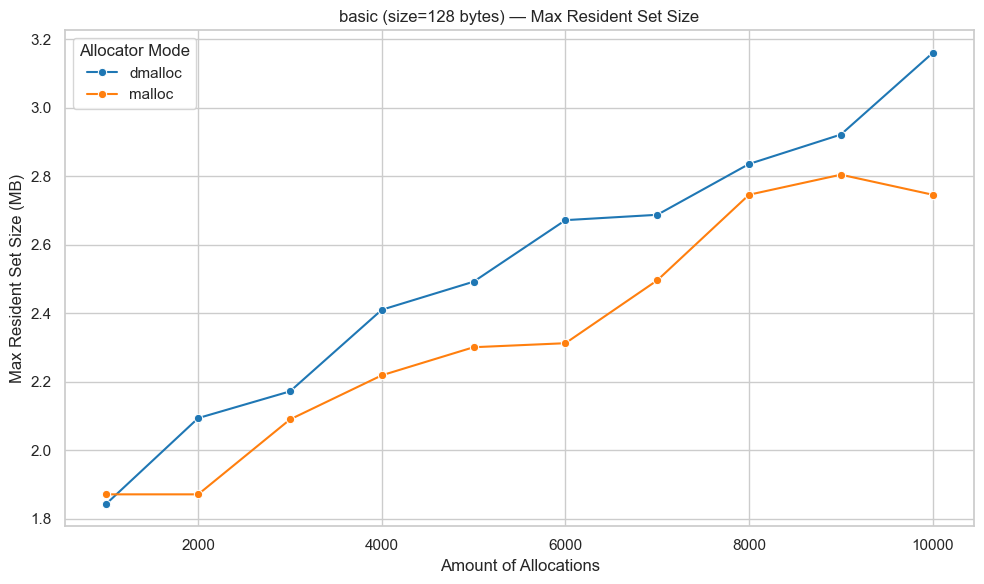

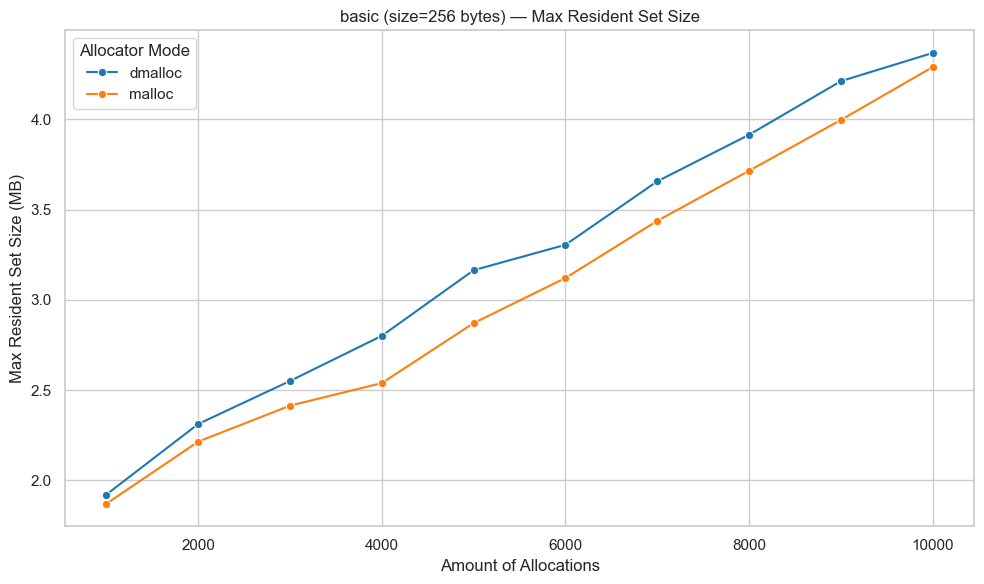

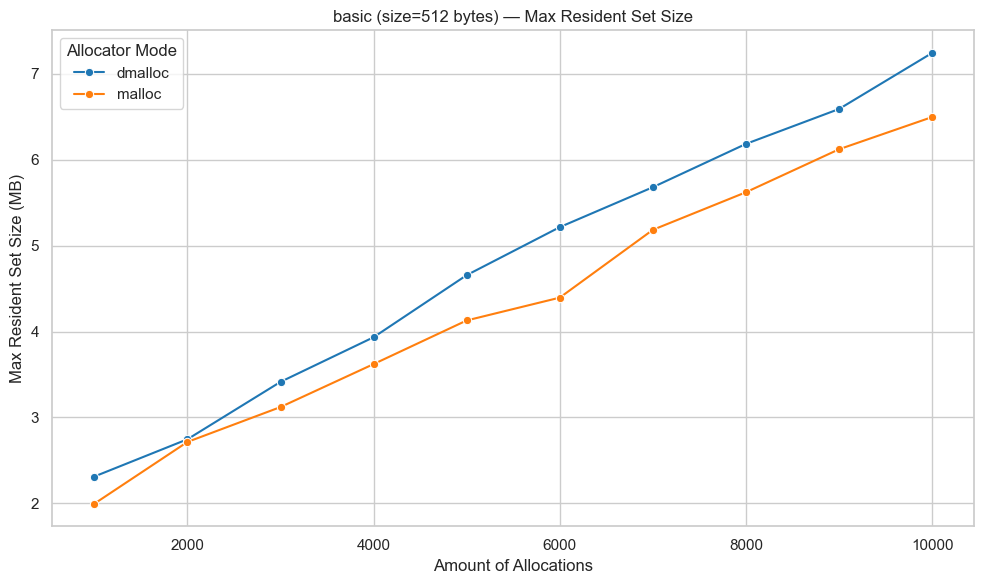

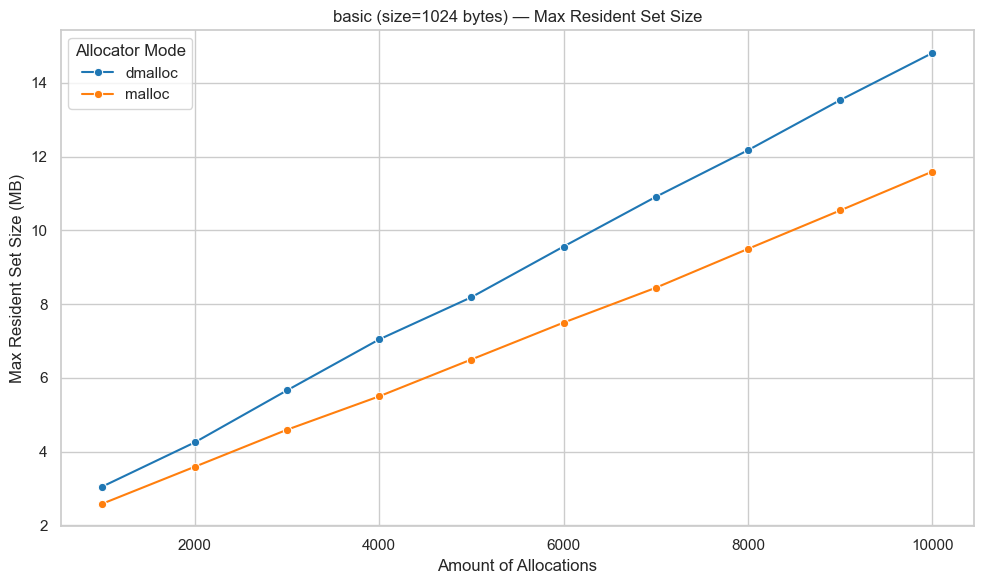

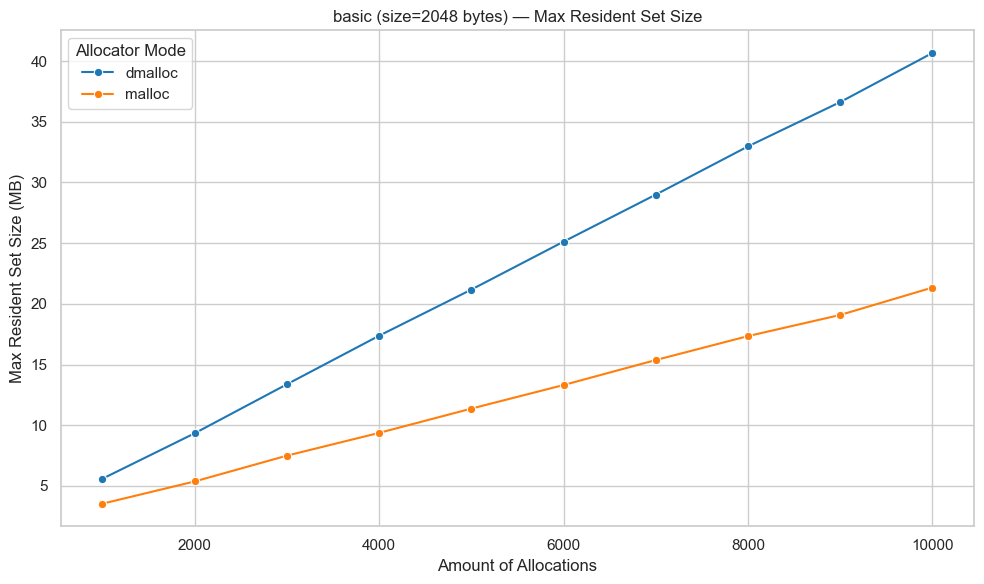

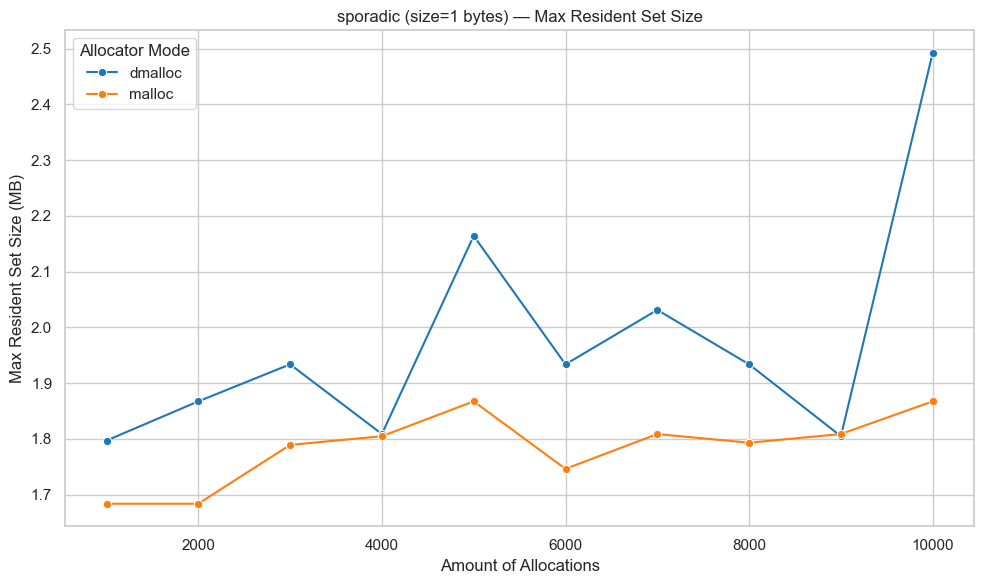

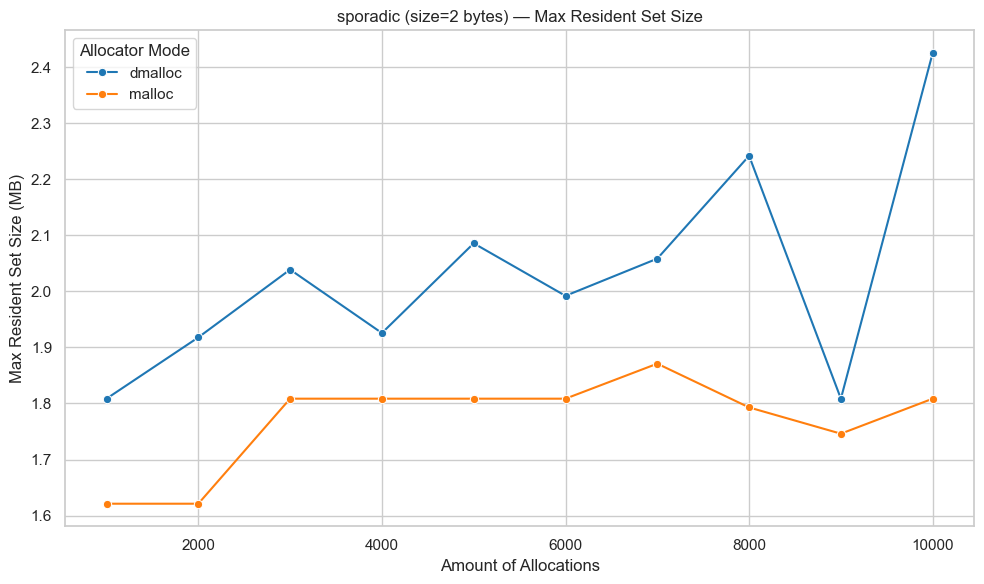

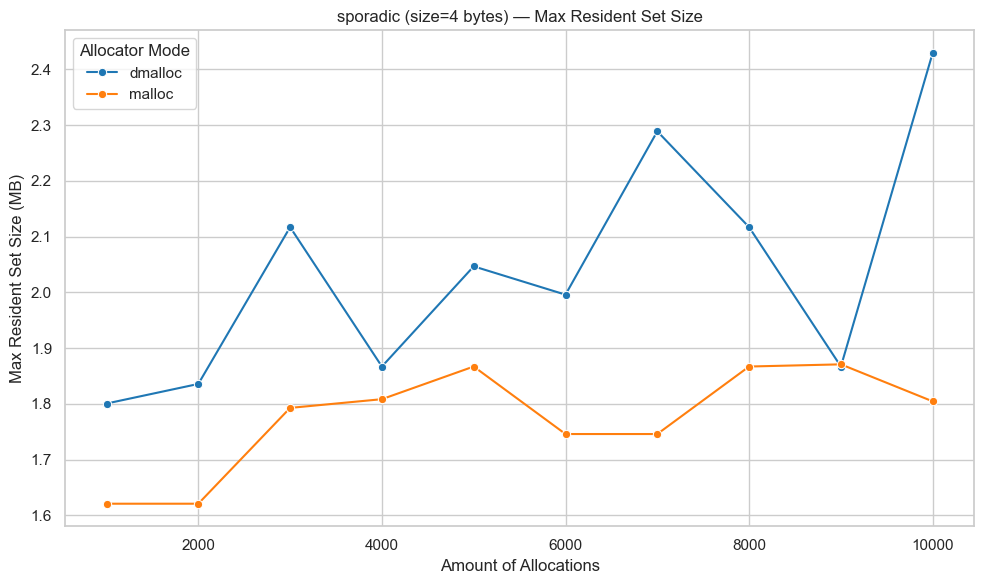

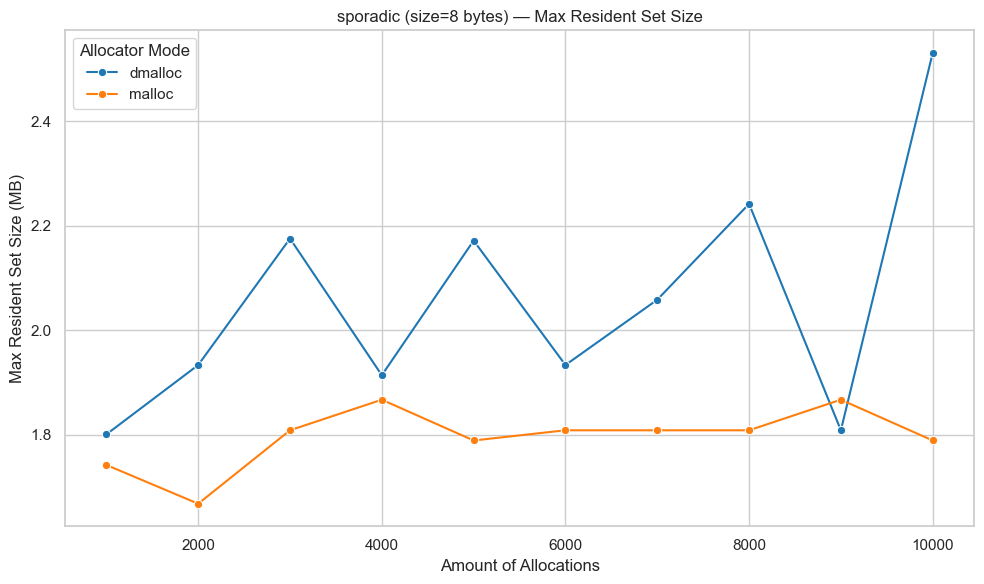

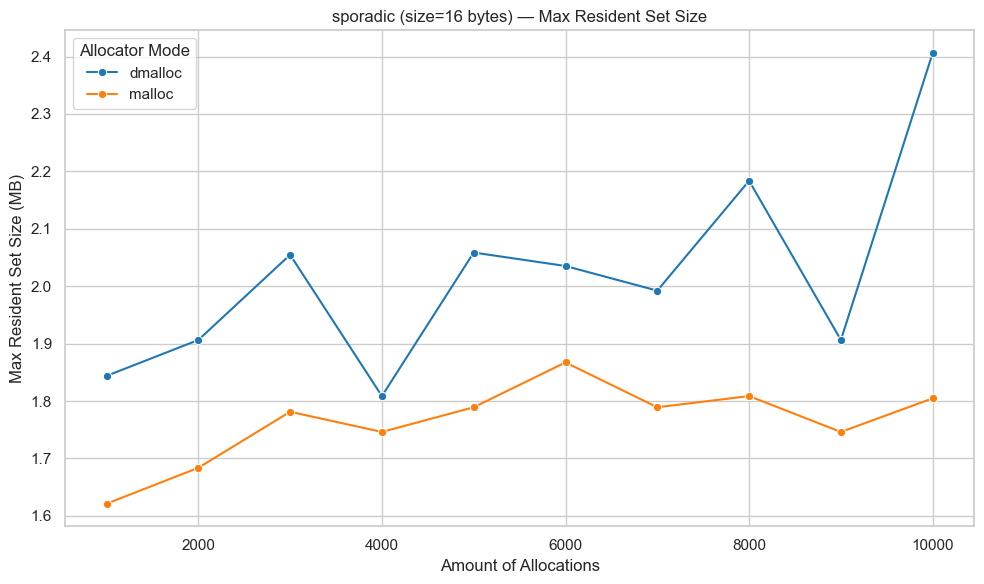

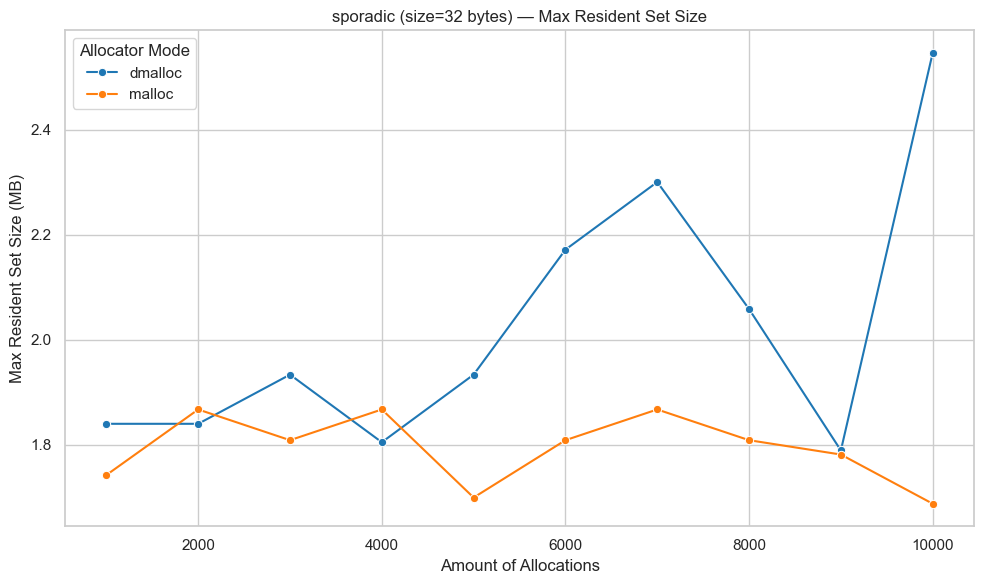

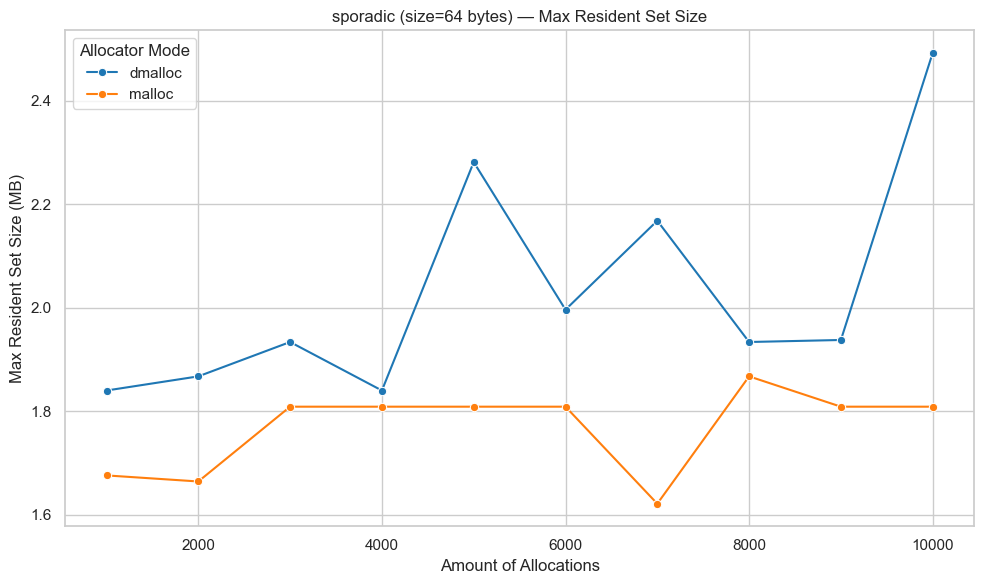

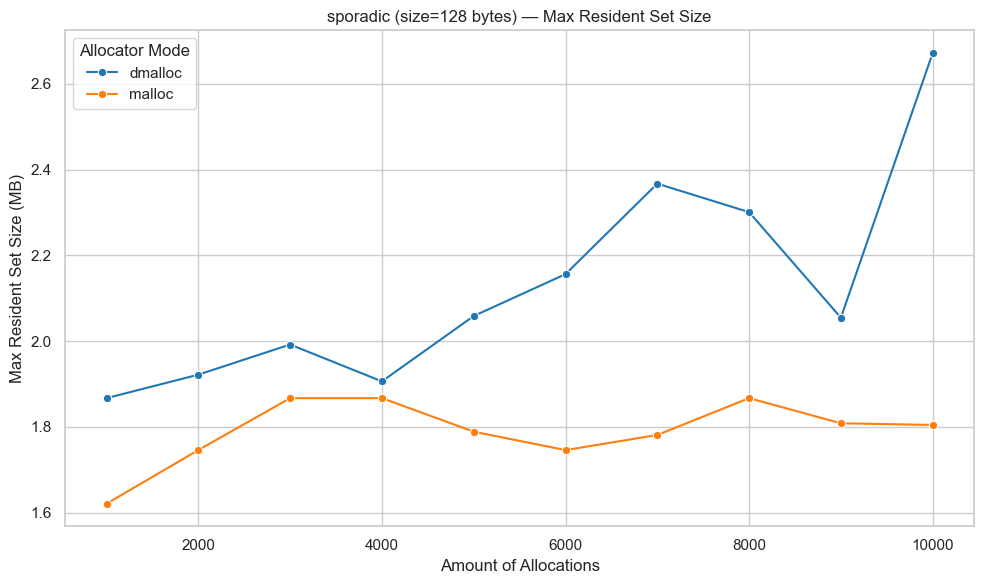

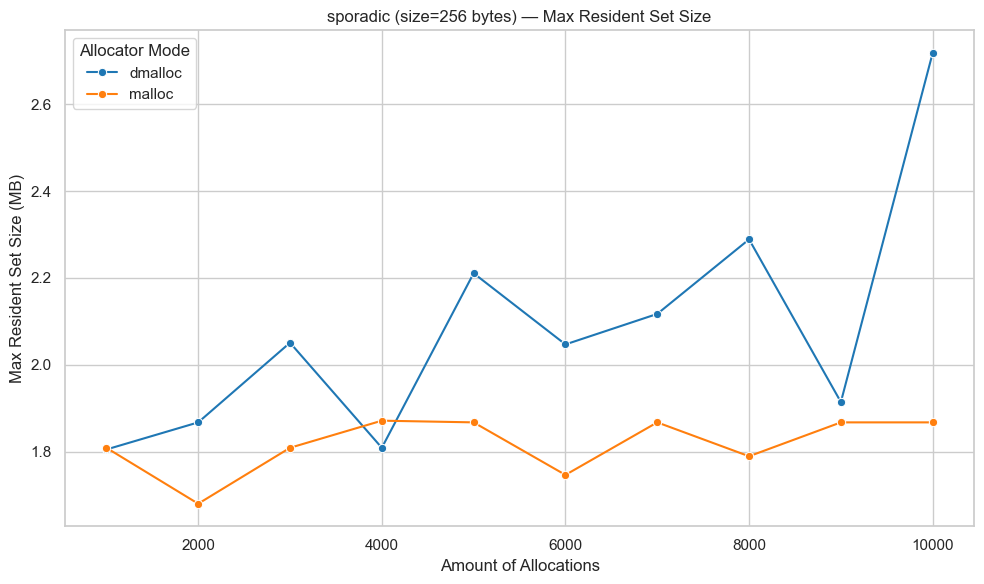

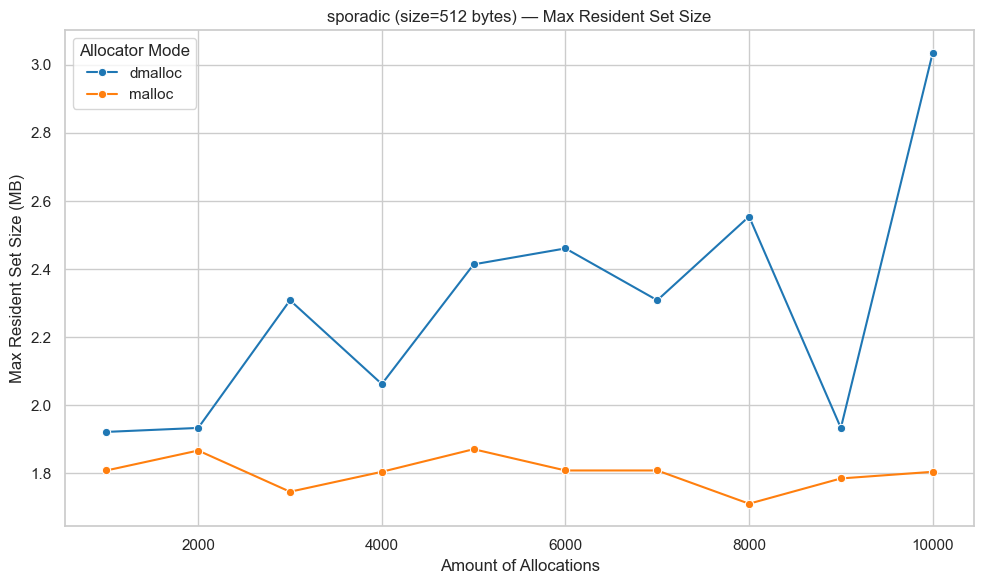

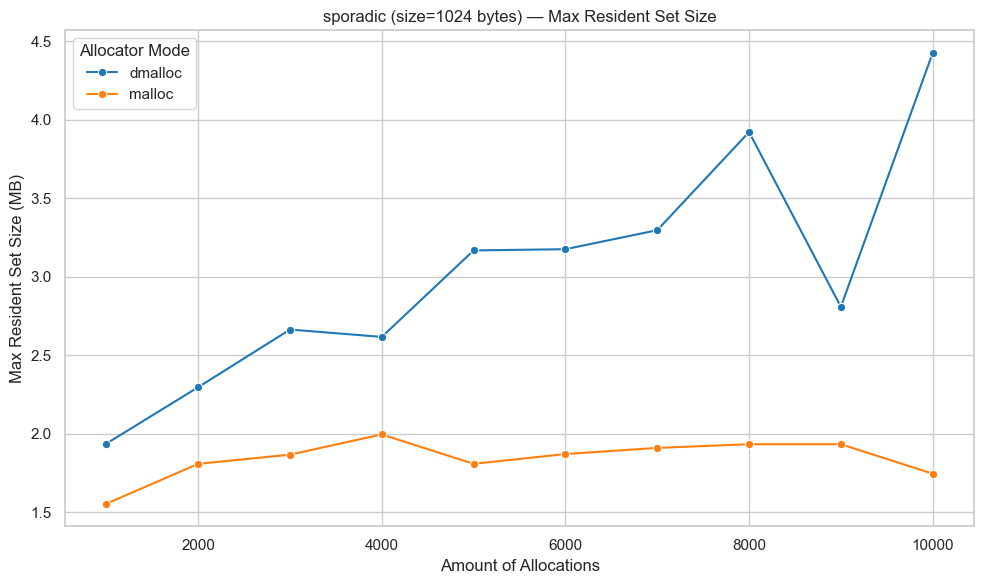

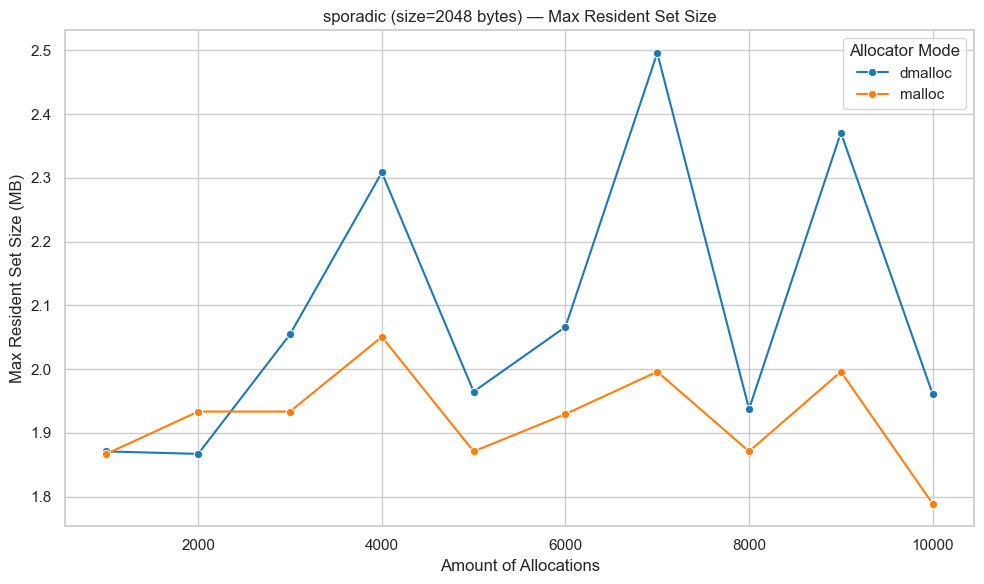

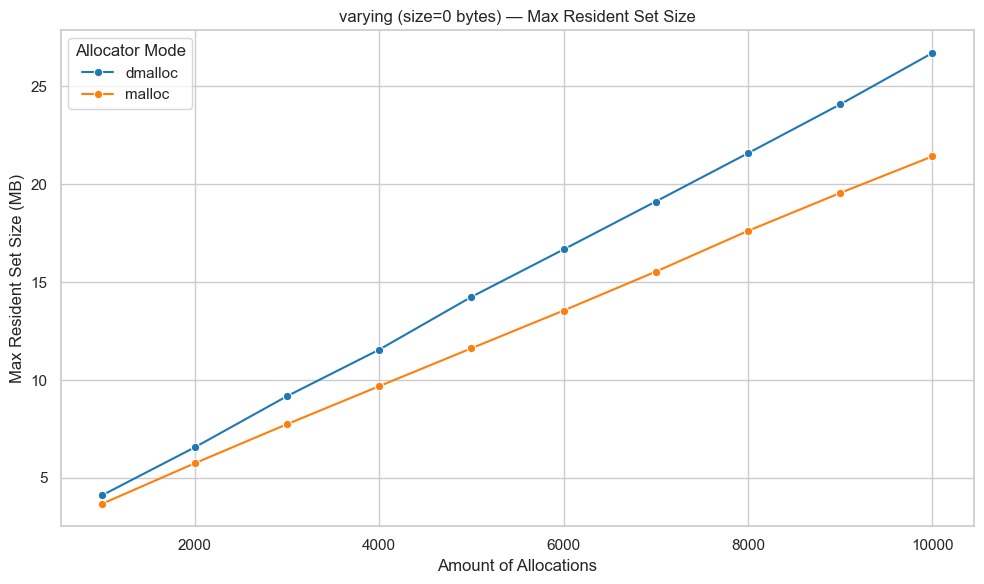

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

sns.set(style="whitegrid")

# Load memory summary CSV
csv_path = "../results/artificial_memory/memory_summary.csv"
df = pd.read_csv(csv_path)

# The CSV may have two formats:
# With size: benchmark,label,amount,size,max_rss_kb
# Without size: benchmark,label,amount,max_rss_kb
# Normalize by adding a size column with -1 where missing
if "size" not in df.columns:
    df["size"] = -1
else:
    df["size"] = df["size"].fillna(-1)

# Convert max_rss_kb to MB for easier plotting
df["max_rss_mb"] = df["max_rss_kb"] / 1024.0

# Extract allocator mode from label (to match your time plots)
# Your label looks like: dmalloc_onlysmall or malloc
# We assume the label column matches this
df["mode"] = df["label"]

# Create output directory
today = datetime.now().strftime("%Y-%m-%d")
output_dir = f"./benchmark_result_graphs/{today}/memory"
os.makedirs(output_dir, exist_ok=True)

palette = sns.color_palette("tab10", n_colors=df["mode"].nunique())
color_mapping = dict(zip(sorted(df["mode"].unique()), palette))

# Plot for each benchmark and size
for benchmark in df["benchmark"].unique():
    bench_df = df[df["benchmark"] == benchmark]

    # Check if there are multiple sizes for this benchmark
    sizes = sorted(bench_df["size"].unique())

    if len(sizes) == 1 and sizes[0] == -1:
        # Only one size (varying or no size) — plot a single graph for this benchmark
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=bench_df,
            x="amount",
            y="max_rss_mb",
            hue="mode",
            marker="o",
            palette=color_mapping,
        )
        plt.title(f"{benchmark} (varying sizes) — Max Resident Set Size")
        plt.xlabel("Amount of Allocations")
        plt.ylabel("Max Resident Set Size (MB)")
        plt.legend(title="Allocator Mode")
        plt.tight_layout()

        safe_benchmark = benchmark.replace("/", "_").replace(" ", "_")
        file_name = f"{safe_benchmark}_memory.png"
        file_path = os.path.join(output_dir, file_name)

        plt.savefig(file_path)
        plt.show()
        plt.close()

    else:
        # Multiple sizes — plot one graph per size
        for size in sizes:
            size_df = bench_df[bench_df["size"] == size]

            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=size_df,
                x="amount",
                y="max_rss_mb",
                hue="mode",
                marker="o",
                palette=color_mapping,
            )
            title_size = f" (size={size} bytes)"
            plt.title(f"{benchmark}{title_size} — Max Resident Set Size")
            plt.xlabel("Amount of Allocations")
            plt.ylabel("Max Resident Set Size (MB)")
            plt.legend(title="Allocator Mode")
            plt.tight_layout()

            safe_benchmark = benchmark.replace("/", "_").replace(" ", "_")
            size_str = str(size)
            file_name = f"{safe_benchmark}_size_{size_str}_memory.png"
            file_path = os.path.join(output_dir, file_name)

            plt.savefig(file_path)
            plt.show()
            plt.close()

